In [2]:
from dataset import CrispDataset
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import tkinter
import matplotlib
import gym
from gym_crisp.envs import CrispEnv
from sklearn.metrics import mean_absolute_error as mae

matplotlib.use('TkAgg')

In [3]:
def fun(w, x_train, y):
    f = w[0] * x[:, 0] + w[1] * x[:, 1] + w[2] * x[:, 2] + w[3] * x[:, 3]
    f[f < 0] = 0
    f.astype(int)
    return f - y


def calculate_order(x_train, w1, w2, w3, w4, method='multiple'):
    # for calculating multiple observation:
    if method == 'multiple':
        f = (w1 * x[:, 0] + w2 * x[:, 1] + w3 * x[:, 2] + w4 * x[:, 3]).astype(int)
        f[f < 0] = 0
        return f
    # for calculating single observation:
    elif method == 'single':
        return max(0, int(w1 * x[0] + w2 * x[1] + w3 * x[2] + w4 * x[3]))

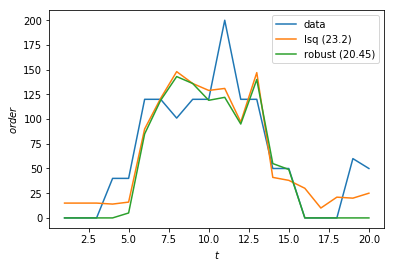

In [17]:
expert_data_path = "datasets/player_state_actions/"

dataset = CrispDataset(expert_data_path)
order = dataset.order
inventory = dataset.inventory
demand = dataset.demand
backlog = dataset.backlog
shipment = dataset.shipment

data = pd.DataFrame(columns=['order', 'inventory', 'shipment', 'demand', 'backlog'])

players_to_ignore = [10, 19, 11, 14]

for i in range(2, 3):
    if i not in players_to_ignore:
        data = data.append(
            pd.concat([order.iloc[i, 0:20], inventory.iloc[i, 0:20], shipment.iloc[i, 0:20],
                      demand.iloc[i, 0:20], backlog.iloc[i, 0:20]],
                      axis=1,
                      keys=['order', 'inventory', 'shipment', 'demand', 'backlog']), ignore_index=True)
        
w0 = np.ones(4)
y_train = data.iloc[:20, 0].to_numpy(dtype=int)
x_train = data.iloc[:20, 1:5].to_numpy(dtype=int)

res_lsq = least_squares(fun, w0, args=(x_train, y_train))
res_robust = least_squares(fun, w0, loss='soft_l1', f_scale=0.1, args=(x_train, y_train))

y_test = data.iloc[:20, 0].to_numpy(dtype=int)
x_test = data.iloc[:20, 1:5].to_numpy(dtype=int)

y_lsq = calculate_order(x_test, *res_lsq.x)
y_robust = calculate_order(x_test, *res_robust.x)

mean_lsq = y_lsq.mean()
mean_robust = y_robust.mean()
mean_y = y_train.mean()

plt.plot(np.array(range(1, 21)), y_train, label='data')
plt.plot(np.array(range(1, 21)), y_lsq, label=f'lsq ({mae(y_train, y_lsq)})')
plt.plot(np.array(range(1, 21)), y_robust, label=f'robust ({ mae(y_train, y_robust)})')
plt.xlabel('$t$')
plt.ylabel('$order$')
plt.legend()
plt.show()

In [15]:
# y_train = pd.DataFrame(np.array_split(y_train, 22))
# y_lsq = pd.DataFrame(np.array_split(y_lsq, 68))
# y_robust = pd.DataFrame(np.array_split(y_robust, 22))


ValueError: x and y must be the same size

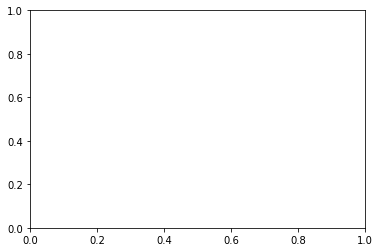

In [18]:
from sklearn.svm import SVR

time = np.array(range(1, 21))
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(time, y_train).predict(time)
y_lin = svr_lin.fit(time, y_train).predict(time)
y_poly = svr_poly.fit(time, y_train).predict(time)

lw = 2
plt.scatter(np.array(range(1, 21)), y_train, color='darkorange', label='data')
# plt.hold('on')
plt.plot(np.array(range(1, 21)), y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(np.array(range(1, 21)), y_lin, color='c', lw=lw, label='Linear model')
plt.plot(np.array(range(1, 21)), y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()
